In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping
%matplotlib inline

In [26]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reset_index()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

In [27]:
df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train, y_train = dataframe_to_xy(df_train, 2)
X_valid, y_valid = dataframe_to_xy(df_valid, 2)
X_test, y_test = dataframe_to_xy(df_test, 2)

In [19]:
X_train.shape

(1126, 1, 8)

In [28]:
def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim, activation='relu'))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def plot_results(y_pred, y_true, history, model_name):
    plt.title('Coût et coût de validation de {}'.format(model_name))
    line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
    line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
    first_legend = plt.legend(handles=[line1, line2], loc=1)

    plt.show()

    plt.title('y_pred en fonction de y_test')

    plt.plot(y_pred[:], y_test[:], '+')
    plt.ylabel('Test')
    plt.xlabel('Prédiction')
    plt.show()
    
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Train on 1125 samples, validate on 561 samples
Epoch 1/5000
1125/1125 [==============================] - 0s - loss: 2075.7488 - val_loss: 2572.9695
Epoch 2/5000
1125/1125 [==============================] - 0s - loss: 1767.0234 - val_loss: 1952.3003
Epoch 3/5000
1125/1125 [==============================] - 0s - loss: 868.7621 - val_loss: 656.1599
Epoch 4/5000
1125/1125 [==============================] 

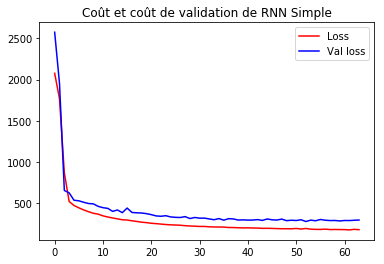

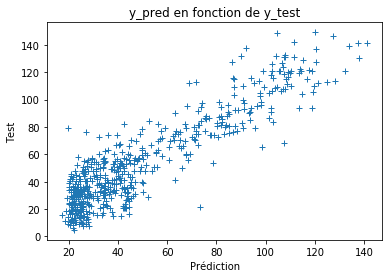

In [29]:
model = simple_rnn_model(32, X_train.shape[1:])
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1 ,shuffle=True)
y_pred = model.predict(X_test)

plot_results(y_pred, y_test, history, 'RNN Simple')

In [ ]:
def